# Homework 1 - Advanced Word Count Analysis
>  **Data Mining Class, 2022, JBNU**

아래 문제를 잘 읽고 PySpark을 이용하여 skeleton 코드를 구현하고 질문에 답하세요. 아래 이미 작성된 코드는 수정할 필요가 없으며 `Fill your code here` 부분을 완성하면 됩니다. **아래 학번과 이름을  적어주세요.**

* **학번**: 201911832
* **이름**: 서민석

## Submission Guidline (제출요령)
모든 코드를 완성하고 난뒤에는 각 cell을 순차적으로 수행하여 결과를 출력하고 상단 메뉴에서 `파일 => 다운로드 => .ipynb 다운로드`를 클릭해서 파일을 다운받습니다. **이때 파일 이름은 반드시 `HW1_이름_학번.ipynb`으로 변경해주셔야 합니다.** 다음 다운로드 받은 파일을 LMS에 제출해주시면 됩니다. 
* 파일명 예시: HW1_이름_202212345.ipynb



## Overview

이번 과제에서는 Spark을 활용하여 입력 문서로 부터 word count를 분석하는 프로그램을 작성하는 것이 목표입니다. 

In [1]:
!pip install -q pyspark py4j --quiet
!pip install -q wordcloud --quiet

     |████████████████████████████████| 281.3 MB 47 kB/s 
     |████████████████████████████████| 200 kB 67.0 MB/s 
     |████████████████████████████████| 199 kB 67.5 MB/s 


### Setup
아래 코드를 실행해서 과제에 필요한 package들을 설치해주세요. 

## Advanced Word Count Problem
### Problem Introduction
Advanced word count 문제는 raw text 파일 하나를 읽어서 단어의 등장횟수를 세는데 이때 다음을 만족해야 합니다. 
* **Step 1 - Tokenization**: 문서에서 각 줄 (line)을 공백을 기준으로 단어를 나누어 세야합니다. 
* **Step 2 - Lower case**: 모든 단어는 소문자 (lower case)로 표현되어야 합니다. 
* **Step 3 - Punctuation removal**: 단어에 punctuation character가 있는 경우 제거되어야 합니다.
    - punctuation는 문장부호/구두점을 의미합니다 => !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
    - 예로 `word!`가 주어지면 !를 제거해 `word`로 변환합니다.
* **Step 4 - Alphabetical words**: 알파벳으로만 구성된 단어만 카운트합니다.
    - 예로 a043와 같은 단어는 제외합니다. 
* **Step 5 - Stopword removal**: Stopword (불용어)는 제외합니다. 
    - stopword는 분석에 큰 의미가 없는 단어들을 지칭합니다 (입력으로 같이 주어짐). 
    - 예로 the, a, is 가 대표적인 불용어입니다. 


### Data Preparation
Word count를 하기 위한 문서와 stopword는 다음 코드를 통해서 다운로드 받을 수 있습니다. 실행이 끝나면 왼쪽메뉴의 폴더 아이콘을 클릭해 `harryporter.txt`와 `stopwords.txt`를 확인할 수 있습니다. 
* 해리포터 1권에 해당하는 text로 현재 teaching을 위해서 licence가 open되어 있습니다. [[link]](https://www.jkrowling.com/j-k-rowling-grants-open-licence-for-teachers-during-covid-19-outbreak/)
* stopwords는 [[link]](https://www.ranks.nl/stopwords)에서 발췌했습니다. 

In [2]:
!wget -nc -q https://raw.githubusercontent.com/jinhongjung/raw_data/master/assignment1/harrypotter.txt
!wget -nc -q https://raw.githubusercontent.com/jinhongjung/raw_data/master/assignment1/stopwords.txt

파일의 데이터를 살펴보기 위해서 다음 명령어를 실행합니다.

In [3]:
!head harrypotter.txt # display first 10 lines

Harry Potter and the Sorcerer's Stone


CHAPTER ONE

THE BOY WHO LIVED

Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say
that they were perfectly normal, thank you very much. They were the last
people you'd expect to be involved in anything strange or mysterious,


In [4]:
!tail harrypotter.txt # display last 10 lines


"Hope you have -- er -- a good holiday," said Hermione, looking
uncertainly after Uncle Vernon, shocked that anyone could be so
unpleasant.

"Oh, I will," said Harry, and they were surprised at the grin that was
spreading over his face. "They don't know we're not allowed to use magic
at home. I'm going to have a lot of fun with Dudley this summer...."

THE END

In [5]:
!head stopwords.txt

a
about
above
after
again
against
all
am
an
and


파일의 내용을 보면 `harryporter.txt`에서는 대소문자, 개행, 문장부호, 구두점들이 혼재되어 있는 것을 확인할 수 있습니다. `stopwords.txt`에서는 영어 단어의 대표적인 stopword들을 확인할 수 있습니다. 

### Program Implementation for Word Count

이제 본격적으로 pyspark를 이용하여 word count를 구현할 단계입니다. 

#### Spark Initialization
먼저 SparkConext를 생성하여 spark를 초기화해줍니다. 

In [6]:
from pyspark import SparkContext

sc = SparkContext("local", "word_count")

#### Data Load and RDD Creation

textFile()을 이용해서 text 데이터를 읽어옵니다. `harrypotter.txt`는 `doc_rdd`에 RDD 형태로 저장되고 `stopwords.txt`는 읽어와서 set의 형태로 저장해둡니다. 

In [7]:
doc_path = "./harrypotter.txt"
stopword_path = "./stopwords.txt"

doc_rdd = sc.textFile(doc_path)
stopwords = set(sc.textFile(stopword_path).collect())

#### Q1. Word Count Function Implementation [50 points]
아래 `get_word_count` 함수를 완성하세요. `get_word_count` 함수는 doc_rdd를 받아서 위 조건을 만족하면서 최종적으로 (word, count)의 집합의 RDD가 wc_rdd에 저장되어 반환되어야 합니다. 
* **조건1**: RDD transformation API로만 구현해야합니다.
* **조건2**: 출력의 일관성을 위하여 RDD transformation을 적용할 때 **반드시 아래 step 순으로 진행**해야 합니다. 
    * **Step 1 - Tokenization**
        - Hint: Python string의 `split()` 함수를 참고하세요. 
    * **Step 2 - Lower case**
        - Hint: Python string의 `lower()` 함수를 참고하세요.
    * **Step 3 - Punctuation removal**
        - Hint: `str.translate(str.maketrans('', '', string.punctuation))`를 수행하면 punctuation을 쉽게 제거할 수 있습니다. 
    * **Step 4 - Alphabetical words**
        - Hint: Python string의 `isalpha()` 함수를 참고하세요.
    * **Step 5 - Stopword removal**
        - Hint: 입력으로 주어지는 stopwords를 활용하세요. 


In [75]:
import string 

def get_word_count(doc_rdd, stopwords):
    wc_rdd = None

    # step 1
    rdd1 = doc_rdd.flatMap(lambda x: x.split(" ")).filter(lambda x: x != '')

    # step 2
    rdd2 = rdd1.map(lambda x: x.lower())

    # step 3
    rdd3 = rdd2.map(lambda x: x.translate(x.maketrans('', '', string.punctuation)))

    # step 4
    rdd4 = rdd3.filter(lambda x: x.isalpha())

    # step 5
    rdd5 = rdd4.filter(lambda x: x not in stopwords)

    wc_rdd = rdd5

    return wc_rdd

wc_rdd = get_word_count(doc_rdd, stopwords)
#print(wc_rdd.collect())

#### Q2. Result Analysis [10 points]

* **Number of words** [5 points]: `wc_rdd` 결과에서 고유한 단어의 개수를 `num_words`에 저장하고 출력하세요. 

In [76]:
num_words = 0

wc_rdd = wc_rdd.map(lambda x: (x, 1)).reduceByKey(lambda a, b: a + b)
print(wc_rdd.collect())

num_words = wc_rdd.count()

print("# of words: {}".format(num_words))

[('harry', 1214), ('potter', 95), ('sorcerers', 16), ('stone', 75), ('chapter', 17), ('one', 255), ('boy', 83), ('lived', 9), ('mr', 81), ('mrs', 46), ('dursley', 54), ('number', 17), ('four', 32), ('privet', 16), ('drive', 20), ('proud', 7), ('say', 75), ('perfectly', 5), ('normal', 10), ('thank', 8), ('much', 76), ('last', 82), ('people', 92), ('expect', 13), ('involved', 5), ('anything', 74), ('strange', 22), ('mysterious', 6), ('just', 180), ('hold', 12), ('nonsense', 4), ('director', 2), ('firm', 2), ('called', 44), ('grunnings', 2), ('made', 66), ('drills', 6), ('big', 28), ('beefy', 1), ('man', 33), ('hardly', 22), ('neck', 18), ('although', 11), ('large', 51), ('mustache', 6), ('thin', 10), ('blonde', 2), ('nearly', 37), ('twice', 15), ('usual', 18), ('amount', 1), ('came', 75), ('useful', 6), ('spent', 11), ('time', 119), ('craning', 2), ('garden', 6), ('fences', 1), ('spying', 3), ('neighbors', 3), ('dursleys', 52), ('small', 32), ('son', 9), ('dudley', 116), ('opinion', 5), 

* **Top-k result** [5 points]: count가 높은 순으로 상위 10개의 word와 count를 `top10_words`에 저장하고 나열하세요. 
    - Hint: `takeOrdered()` 함수를 참고하세요.

In [77]:
top10_words = None

top10_words = wc_rdd.sortBy(lambda x: x[1], False).takeOrdered(10, key = lambda x: x * -1)

for item in top10_words:
    print("'{}' appears {} times".format(item[0], item[1]))

'harry' appears 1214 times
'said' appears 794 times
'ron' appears 410 times
'hagrid' appears 336 times
'back' appears 261 times
'hermione' appears 257 times
'one' appears 255 times
'got' appears 198 times
'like' appears 194 times
'get' appears 194 times


#### Word Cloud Visualization
Word cloud는 단어들의 집합을 시각화하는 기법 중에 하나로 단어의 중요도 따라 중요한 단어는 더 크게 보여집니다. Word count 예시에서는 많이 등장하는 단어일 수록 count를 중요도로 설정하여 word cloud를 시각화 할 수 있습니다. 아래 코드를 수행해서 결과를 확인하세요.

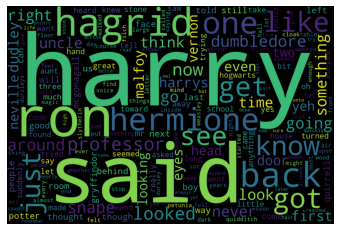

In [78]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

words = dict(wc_rdd.collect())
wordcloud = WordCloud(width=1500, height=1000).generate_from_frequencies(words)
plt.imshow(wordcloud) 
plt.axis('off') 
plt.show()

#### Q3. Word Count Frequency Distribution Visualization [40 points]

* **Compute word count frequency** [20 points]: n번 등장한 단어가 k개 있다면 k를 word count frequency라 합니다. 예를 들어서 ('harry', 5), ('ron', 5), ('hagrid', 5)과 같이 주어진다면 5 (count)번 등장한 단어가 3 (frequency)개 있음을 의미합니다. 이와 같이 word count에 대응되는 frequency를 구해 분포를 살펴보려고 할때 아래 `get_count_freq()` 함수를 완성하세요. 입력으로는 (word, count) 집합의 RDD (`wc_rdd`)가 주어지고 출력으로는 (count, frequency) 집합의 RDD (`count_freq_rdd`)가 반환되어야 합니다. 이 함수 역시 RDD transformation API로만 구현되어야 합니다. 

In [94]:
def get_count_freq(wc_rdd):
    count_freq_rdd = None
    
    count_freq_rdd = wc_rdd.values().map(lambda x: (x, 1)).reduceByKey(lambda a, b: a + b)

    return count_freq_rdd

count_freq_rdd = get_count_freq(wc_rdd)

[(1214, 1), (95, 3), (16, 35), (75, 4), (17, 23), (255, 1), (83, 1), (9, 72), (81, 3), (46, 7), (54, 4), (32, 12), (20, 25), (7, 141), (5, 194), (10, 101), (8, 101), (76, 1), (82, 3), (92, 1), (13, 51), (74, 2), (22, 22), (6, 146), (180, 3), (12, 61), (4, 315), (2, 901), (44, 6), (66, 2), (28, 13), (1, 2574), (33, 6), (18, 39), (11, 64), (51, 2), (37, 8), (15, 34), (119, 1), (3, 518), (52, 3), (116, 1), (30, 7), (123, 1), (69, 4), (14, 46), (19, 29), (53, 5), (21, 19), (64, 2), (126, 2), (105, 4), (55, 4), (70, 1), (194, 2), (36, 7), (43, 7), (29, 10), (63, 4), (166, 1), (71, 4), (77, 2), (198, 1), (25, 11), (111, 1), (129, 1), (23, 19), (99, 1), (142, 1), (57, 5), (27, 8), (35, 3), (261, 1), (794, 1), (98, 1), (42, 2), (58, 2), (49, 6), (96, 2), (24, 16), (59, 4), (45, 4), (72, 2), (47, 5), (31, 8), (41, 5), (86, 1), (67, 2), (38, 4), (188, 1), (94, 1), (39, 2), (125, 1), (169, 1), (91, 1), (34, 11), (88, 1), (50, 2), (26, 10), (48, 6), (62, 2), (93, 1), (90, 2), (135, 1), (100, 2), (

* **Visualize word count frequency distribution** [15 points]: `count_freq_rdd`의 결과로 부터 분포를 시각화 하려고 할때 아래 코드를 완성하세요. 
    - scatter plot으로 그리고 x축은 count이며 y축은 frequency를 의미합니다. 
    - x축 y축 둘 다 log-scale로 표현되어야 합니다. 
    - x축 label은 `Word Count`, y축 label은 `Frequency`로 지정해주세요. 

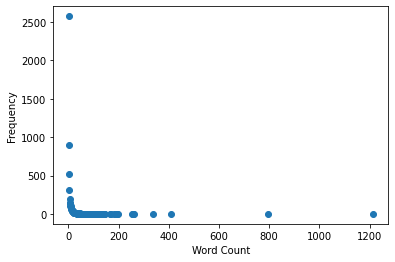

In [107]:
import numpy as np
import matplotlib.pyplot as plt

count_freq = np.array(count_freq_rdd.collect())

count = count_freq[:, 0] # count (x-axis)
freq = count_freq[:, 1]  # frequency (y-axis)

plt.scatter(count, freq)
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

* **Type of distribution** [5 points]: 위 plot의 결과를 보았을 때 word count frequency 분포는 어떠한 분포를 따른다고 볼 수 있을까요? 아래 `which_distribution` 문자열에 정답을 기재하고 실행해 주세요.

In [108]:
which_distribution = "power law" # fill this string
print("The word count frequency follows {} distribution.".format(which_distribution))

The word count frequency follows power law distribution.


### Terminate Spark
Word count 문제는 여기까지 입니다. 아래는 해당 SparkContext를 종료하는 코드입니다.

In [109]:
sc.stop()